# Lab 10: Train CNN on CIFAR-10
This notebook implements the tasks from Lab 10 using PyTorch.

In [24]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Transform: Convert to tensor and normalize
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=8, shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=8, shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

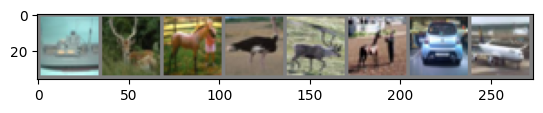

ship  deer  horse bird  deer  horse car   plane


In [26]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Show some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))

## Part A: Default CNN Architecture

In [27]:
class DefaultCNN(nn.Module):
    def __init__(self):
        super(DefaultCNN, self).__init__()
        # Input: 32x32x3
        # Conv1: 5x5, 16 filters, stride 1, pad 2 -> 32x32x16
        self.conv1 = nn.Conv2d(3, 16, 5, stride=1, padding=2)
        self.relu1 = nn.ReLU()
        # Pool1: 2x2, stride 2 -> 16x16x16
        self.pool1 = nn.MaxPool2d(2, 2)
        
        # Conv2: 5x5, 20 filters, stride 1, pad 2 -> 16x16x20
        self.conv2 = nn.Conv2d(16, 20, 5, stride=1, padding=2)
        self.relu2 = nn.ReLU()
        # Pool2: 2x2, stride 2 -> 8x8x20
        self.pool2 = nn.MaxPool2d(2, 2)
        
        # Conv3: 5x5, 20 filters, stride 1, pad 2 -> 8x8x20
        self.conv3 = nn.Conv2d(20, 20, 5, stride=1, padding=2)
        self.relu3 = nn.ReLU()
        # Pool3: 2x2, stride 2 -> 4x4x20
        self.pool3 = nn.MaxPool2d(2, 2)
        
        # FC: 4*4*20 = 320 -> 10
        self.fc = nn.Linear(320, 10)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = x.view(-1, 320)
        x = self.fc(x)
        return x

net = DefaultCNN().to(device)

In [28]:
def train_model(net, trainloader, criterion, optimizer, num_epochs=10):
    start_time = time.time()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 2000 == 1999:
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0
    print('Finished Training')
    print(f"Total time: {time.time() - start_time:.2f}s")

In [29]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
train_model(net, trainloader, criterion, optimizer, num_epochs=10)

[1,  2000] loss: 1.913
[1,  4000] loss: 1.579
[1,  6000] loss: 1.399
[2,  2000] loss: 1.294
[2,  4000] loss: 1.201
[2,  6000] loss: 1.163
[3,  2000] loss: 1.080
[3,  4000] loss: 1.049
[3,  6000] loss: 1.014
[4,  2000] loss: 0.945
[4,  4000] loss: 0.957
[4,  6000] loss: 0.924
[5,  2000] loss: 0.865
[5,  4000] loss: 0.877
[5,  6000] loss: 0.888
[6,  2000] loss: 0.817
[6,  4000] loss: 0.829
[6,  6000] loss: 0.844
[7,  2000] loss: 0.776
[7,  4000] loss: 0.786
[7,  6000] loss: 0.807
[8,  2000] loss: 0.745
[8,  4000] loss: 0.776
[8,  6000] loss: 0.767
[9,  2000] loss: 0.728
[9,  4000] loss: 0.751
[9,  6000] loss: 0.738
[10,  2000] loss: 0.698
[10,  4000] loss: 0.718
[10,  6000] loss: 0.741
Finished Training
Total time: 153.88s


In [30]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total} %')

Accuracy of the network on the 10000 test images: 69.45 %


### A2. Record Training Stats

In [31]:
def train_and_profile(net, trainloader, testloader, criterion, optimizer, num_epochs=1):
    print("Collecting Training Stats...")
    
    forward_times = []
    backward_times = []
    classification_losses = []
    l2_losses = []
    train_accs = []
    examples_seen = 0
    
    net.train()
    
    # We will profile just a subset of batches to get average times
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        batch_size = inputs.size(0)
        examples_seen += batch_size
        
        optimizer.zero_grad()
        
        # Forward pass timing
        t0 = time.time()
        outputs = net(inputs)
        t1 = time.time()
        forward_times.append((t1 - t0) / batch_size)
        
        # Loss
        loss = criterion(outputs, labels)
        classification_losses.append(loss.item())
        
        # L2 Weight Decay Loss (Manual calculation for reporting)
        l2_reg = 0.0
        for param in net.parameters():
            l2_reg += torch.norm(param, 2)**2
        l2_losses.append(l2_reg.item())

        # Backward pass timing
        t2 = time.time()
        loss.backward()
        optimizer.step()
        t3 = time.time()
        backward_times.append((t3 - t2) / batch_size)
        
        # Training Accuracy (batch)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        train_accs.append(correct / batch_size)
        
        if i >= 100: 
            break
            
    # Validation Accuracy
    correct_val = 0
    total_val = 0
    net.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    val_acc = 100 * correct_val / total_val
    
    # Test Accuracy (last 200 images)
    correct_last200 = 0
    total_last200 = 0
    subset_loader = torch.utils.data.DataLoader(testset, batch_size=8, shuffle=False, num_workers=0)
    # Skip to last 200
    start_idx = len(testset) - 200
    for i, data in enumerate(subset_loader):
        if i * subset_loader.batch_size < start_idx:
            continue
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total_last200 += labels.size(0)
        correct_last200 += (predicted == labels).sum().item()
    test_acc_200 = 100 * correct_last200 / total_last200

    # Averages
    avg_fwd = np.mean(forward_times)
    avg_bwd = np.mean(backward_times)
    avg_loss = np.mean(classification_losses)
    avg_l2 = np.mean(l2_losses)
    avg_train_acc = np.mean(train_accs) * 100
    
    print("\n--- Training Stats (A2) ---")
    print(f"Forward time per example: {avg_fwd*1000:.4f} ms")
    print(f"Backprop time per example: {avg_bwd*1000:.4f} ms")
    print(f"Classification Loss: {avg_loss:.4f}")
    print(f"L2 Weight Decay Loss (Sum of Sq Params): {avg_l2:.4f}")
    print(f"Training Accuracy: {avg_train_acc:.2f}%")
    print(f"Validation Accuracy: {val_acc:.2f}%")
    print(f"Examples Seen: {examples_seen}")
    print(f"Test Accuracy (last 200 images): {test_acc_200:.2f}%")

# Run profiling on the DefaultCNN
net_profile = DefaultCNN().to(device)
optimizer_profile = optim.SGD(net_profile.parameters(), lr=0.001, momentum=0.9)
train_and_profile(net_profile, trainloader, testloader, criterion, optimizer_profile)


--- Training Stats (A2) ---
Forward time per example: 0.0485 ms
Backprop time per example: 0.1024 ms
Classification Loss: 2.3029
L2 Weight Decay Loss (Sum of Sq Params): 22.1740
Training Accuracy: 11.39%
Validation Accuracy: 11.32%
Examples Seen: 808
Test Accuracy (last 200 images): 10.50%


### A3. Layer-by-Layer Visualization

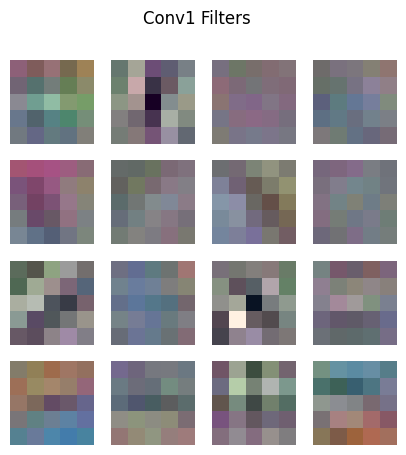

In [32]:
# Visualize first layer filters
filters = net.conv1.weight.data.cpu()
# Normalize filters for visualization
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

fig, axes = plt.subplots(4, 4, figsize=(5, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(filters[i].permute(1, 2, 0))
    ax.axis('off')
plt.suptitle("Conv1 Filters")
plt.show()

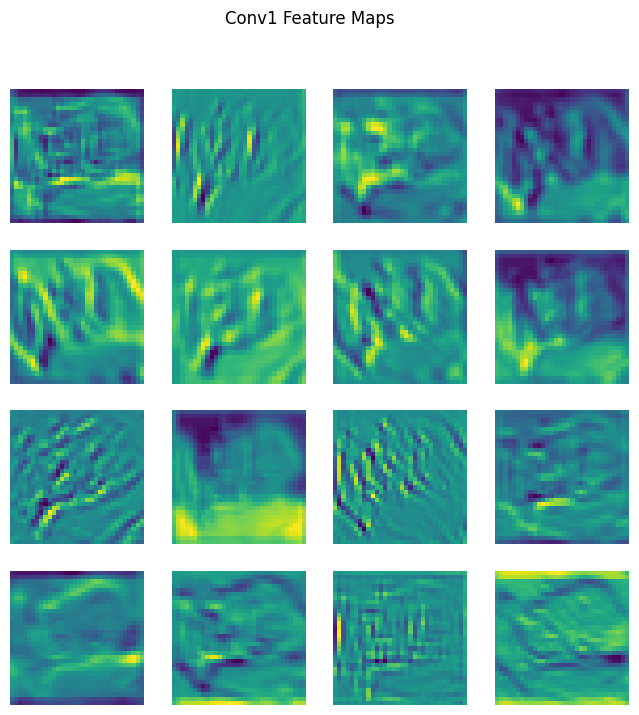

In [33]:
# Visualize feature maps for a sample image
dataiter = iter(testloader)
images, labels = next(dataiter)
img = images[0].unsqueeze(0).to(device)

activations = {}
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

net.conv1.register_forward_hook(get_activation('conv1'))
output = net(img)

act = activations['conv1'].squeeze().cpu()
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(act[i], cmap='viridis')
    ax.axis('off')
plt.suptitle("Conv1 Feature Maps")
plt.show()

### A4. Questions

**1. What features do Conv Layer 1 filters capture?**
They typically capture low-level features such as edges, corners, and color blobs.

**2. Why are Conv Layer 3 activations more abstract?**
As we go deeper, layers combine features from previous layers, representing more complex and abstract patterns (like parts of objects) rather than simple edges.

**3. Do gradients vanish or explode anywhere?**
With ReLU activations and proper initialization (like Xavier/Kaiming), gradients are usually stable. If the network was very deep without residual connections, vanishing gradients could be an issue.

**4. Why is validation accuracy lower than training accuracy?**
This indicates overfitting, where the model learns the training data too well (including noise) but fails to generalize to unseen data.

**5. How does pooling affect spatial resolution?**
Pooling reduces the spatial dimensions (e.g., 2x2 pooling with stride 2 halves the width and height), which reduces computation and makes the representation more invariant to small translations.

## Part B: Hyperparameter Experiments

In [34]:
def run_experiment(lr=0.001, momentum=0.9, batch_size=8, weight_decay=0):
    print(f"Experiment: LR={lr}, Momentum={momentum}, Batch={batch_size}, WD={weight_decay}")
    
    net = DefaultCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    
    loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
    
    # Train for 1 epoch for speed in this demo
    train_model(net, loader, criterion, optimizer, num_epochs=1)
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = 100 * correct / total
    print(f"Accuracy: {acc}%")
    return acc

# Run experiments
print("--- Learning Rate Experiments ---")
run_experiment(lr=0.01)
run_experiment(lr=0.001)

print("\n--- Momentum Experiments ---")
run_experiment(momentum=0.5)

print("\n--- Batch Size Experiments ---")
run_experiment(batch_size=32)

print("\n--- Weight Decay Experiments ---")
run_experiment(weight_decay=0.001)

--- Learning Rate Experiments ---
Experiment: LR=0.01, Momentum=0.9, Batch=8, WD=0
[1,  2000] loss: 1.849
[1,  4000] loss: 1.691
[1,  6000] loss: 1.627
Finished Training
Total time: 15.58s
Accuracy: 43.99%
Experiment: LR=0.001, Momentum=0.9, Batch=8, WD=0
[1,  2000] loss: 1.963
[1,  4000] loss: 1.571
[1,  6000] loss: 1.410
Finished Training
Total time: 15.55s
Accuracy: 52.86%

--- Momentum Experiments ---
Experiment: LR=0.001, Momentum=0.5, Batch=8, WD=0
[1,  2000] loss: 2.271
[1,  4000] loss: 1.996
[1,  6000] loss: 1.793
Finished Training
Total time: 16.26s
Accuracy: 38.27%

--- Batch Size Experiments ---
Experiment: LR=0.001, Momentum=0.9, Batch=32, WD=0
Finished Training
Total time: 10.19s
Accuracy: 41.23%

--- Weight Decay Experiments ---
Experiment: LR=0.001, Momentum=0.9, Batch=8, WD=0.001
[1,  2000] loss: 1.978
[1,  4000] loss: 1.553
[1,  6000] loss: 1.416
Finished Training
Total time: 17.38s
Accuracy: 52.16%


52.16

### B1. Observations

* **Learning Rate**: High LR (0.01) might cause instability or faster convergence depending on the schedule. Very high LR can cause divergence.
* **Momentum**: Higher momentum (0.9) usually helps accelerate training and dampens oscillations compared to lower momentum (0.5).
* **Batch Size**: Larger batch sizes (32) provide more stable gradient estimates but might converge to sharp minima. Smaller batch sizes (4) are noisier but can generalize better.
* **Weight Decay**: Adding L2 regularization helps prevent overfitting.

## Part C: Different Architectures

In [35]:
# Shallow Network
class ShallowCNN(nn.Module):
    def __init__(self):
        super(ShallowCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 5, stride=1, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        # Output after pool: 16x16x8 = 2048
        self.fc = nn.Linear(2048, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = x.view(-1, 2048)
        x = self.fc(x)
        return x

print("Training Shallow Network...")
net_shallow = ShallowCNN().to(device)
optimizer = optim.SGD(net_shallow.parameters(), lr=0.001, momentum=0.9)
train_model(net_shallow, trainloader, criterion, optimizer, num_epochs=10)

Training Shallow Network...
[1,  2000] loss: 1.679
[1,  4000] loss: 1.437
[1,  6000] loss: 1.389
[2,  2000] loss: 1.274
[2,  4000] loss: 1.276
[2,  6000] loss: 1.251
[3,  2000] loss: 1.174
[3,  4000] loss: 1.198
[3,  6000] loss: 1.185
[4,  2000] loss: 1.132
[4,  4000] loss: 1.152
[4,  6000] loss: 1.147
[5,  2000] loss: 1.100
[5,  4000] loss: 1.119
[5,  6000] loss: 1.116
[6,  2000] loss: 1.063
[6,  4000] loss: 1.087
[6,  6000] loss: 1.111
[7,  2000] loss: 1.055
[7,  4000] loss: 1.070
[7,  6000] loss: 1.084
[8,  2000] loss: 1.032
[8,  4000] loss: 1.062
[8,  6000] loss: 1.071
[9,  2000] loss: 1.016
[9,  4000] loss: 1.046
[9,  6000] loss: 1.064
[10,  2000] loss: 1.017
[10,  4000] loss: 1.034
[10,  6000] loss: 1.049
Finished Training
Total time: 128.16s


In [36]:
# Deep Network
class DeepCNN(nn.Module):
    def __init__(self):
        super(DeepCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x))) # 16x16
        x = self.pool(torch.relu(self.conv2(x))) # 8x8
        x = self.pool(torch.relu(self.conv3(x))) # 4x4
        x = x.view(-1, 128 * 4 * 4)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

print("Training Deep Network...")
net_deep = DeepCNN().to(device)
optimizer = optim.SGD(net_deep.parameters(), lr=0.001, momentum=0.9)
train_model(net_deep, trainloader, criterion, optimizer, num_epochs=10)

Training Deep Network...
[1,  2000] loss: 2.068
[1,  4000] loss: 1.616
[1,  6000] loss: 1.429
[2,  2000] loss: 1.268
[2,  4000] loss: 1.178
[2,  6000] loss: 1.080
[3,  2000] loss: 0.982
[3,  4000] loss: 0.921
[3,  6000] loss: 0.899
[4,  2000] loss: 0.800
[4,  4000] loss: 0.767
[4,  6000] loss: 0.757
[5,  2000] loss: 0.644
[5,  4000] loss: 0.665
[5,  6000] loss: 0.639
[6,  2000] loss: 0.547
[6,  4000] loss: 0.533
[6,  6000] loss: 0.542
[7,  2000] loss: 0.413
[7,  4000] loss: 0.437
[7,  6000] loss: 0.470
[8,  2000] loss: 0.324
[8,  4000] loss: 0.348
[8,  6000] loss: 0.369
[9,  2000] loss: 0.227
[9,  4000] loss: 0.268
[9,  6000] loss: 0.284
[10,  2000] loss: 0.168
[10,  4000] loss: 0.202
[10,  6000] loss: 0.209
Finished Training
Total time: 155.07s


### C1. Comparison

* **Shallow Network**: Likely to have lower accuracy due to limited capacity to learn complex features.
* **Deep Network**: Should achieve higher accuracy but takes longer to train and is more prone to overfitting if data is limited (though CIFAR-10 is decent size).

## Validation Outputs Visualization
Visualizing model predictions with probabilities.

Visualizing predictions for DefaultCNN:


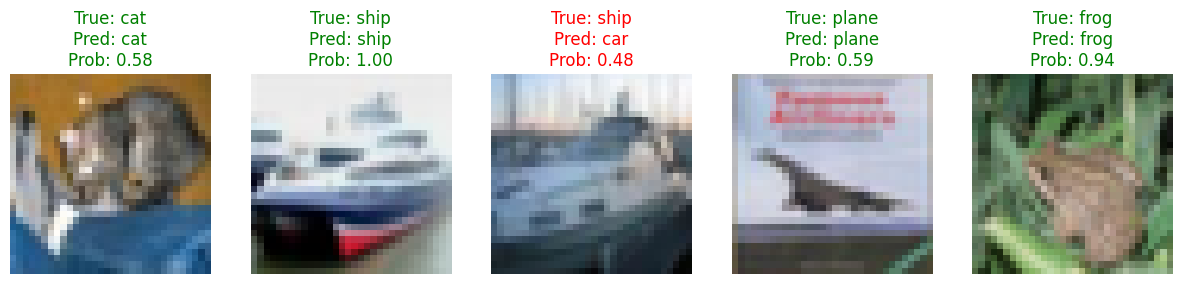

In [37]:
import torch.nn.functional as F

def visualize_predictions(model, loader, num_images=5):
    dataiter = iter(loader)
    images, labels = next(dataiter)
    
    # Move to device
    images, labels = images.to(device), labels.to(device)
    
    # Get outputs
    outputs = model(images)
    # Get probabilities
    probs = F.softmax(outputs, dim=1)
    # Get predictions
    max_probs, predicted = torch.max(probs, 1)
    
    # Move back to cpu for plotting
    images = images.cpu()
    labels = labels.cpu()
    predicted = predicted.cpu()
    max_probs = max_probs.cpu()
    
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        if i >= len(images): break
        img = images[i] / 2 + 0.5     # unnormalize
        npimg = img.numpy()
        axes[i].imshow(np.transpose(npimg, (1, 2, 0)))
        
        true_label = classes[labels[i]]
        pred_label = classes[predicted[i]]
        prob = max_probs[i].item()
        
        color = 'green' if true_label == pred_label else 'red'
        axes[i].set_title(f"True: {true_label}\nPred: {pred_label}\nProb: {prob:.2f}", color=color)
        axes[i].axis('off')
    plt.show()

print("Visualizing predictions for DefaultCNN:")
visualize_predictions(net, testloader)

### 5. Extended Evaluation
- Confusion Matrix for all models
- Save all models

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(net, loader, classes, title="Confusion Matrix"):
    y_true = []
    y_pred = []
    net.eval()
    with torch.no_grad():
        for data in loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Plot Confusion Matrices
print("Plotting Confusion Matrices...")
plot_confusion_matrix(net, testloader, classes, title="Default CNN Confusion Matrix")
plot_confusion_matrix(net_shallow, testloader, classes, title="Shallow CNN Confusion Matrix")
plot_confusion_matrix(net_deep, testloader, classes, title="Deep CNN Confusion Matrix")

# Save Models
print("Saving Models...")
torch.save(net.state_dict(), 'default_cnn.pth')
torch.save(net_shallow.state_dict(), 'shallow_cnn.pth')
torch.save(net_deep.state_dict(), 'deep_cnn.pth')
print("Models saved: default_cnn.pth, shallow_cnn.pth, deep_cnn.pth")

Plotting Confusion Matrices...


### Model Comparison
Comparing the performance of all three CNN architectures

In [ ]:
# Compare all three models
print("\n=== Model Comparison ===")
print("\nModel Architectures:")
print("-" * 60)

# Default CNN
print("\n1. Default CNN:")
print("   - Conv1: 3->16 (5x5) + ReLU + MaxPool")
print("   - Conv2: 16->20 (5x5) + ReLU + MaxPool")
print("   - Conv3: 20->20 (5x5) + ReLU + MaxPool")
print("   - FC: 320->10")
total_params_default = sum(p.numel() for p in net.parameters())
print(f"   - Total Parameters: {total_params_default:,}")

# Shallow CNN
print("\n2. Shallow CNN:")
print("   - Conv: 3->8 (5x5) + ReLU + MaxPool")
print("   - FC: 2048->10")
total_params_shallow = sum(p.numel() for p in net_shallow.parameters())
print(f"   - Total Parameters: {total_params_shallow:,}")

# Deep CNN
print("\n3. Deep CNN:")
print("   - Conv1: 3->32 (3x3) + ReLU + MaxPool")
print("   - Conv2: 32->64 (3x3) + ReLU + MaxPool")
print("   - Conv3: 64->128 (3x3) + ReLU + MaxPool")
print("   - FC1: 2048->256 + ReLU")
print("   - FC2: 256->10")
total_params_deep = sum(p.numel() for p in net_deep.parameters())
print(f"   - Total Parameters: {total_params_deep:,}")

# Test all models
print("\n" + "=" * 60)
print("\nTest Accuracy Comparison:")
print("-" * 60)

models = [
    ('Default CNN', net),
    ('Shallow CNN', net_shallow),
    ('Deep CNN', net_deep)
]

results = []
for name, model in models:
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    results.append((name, accuracy))
    print(f"{name:15s}: {accuracy:.2f}%")

# Summary
print("\n" + "=" * 60)
print("\nSummary:")
print("-" * 60)
best_model = max(results, key=lambda x: x[1])
print(f"Best performing model: {best_model[0]} ({best_model[1]:.2f}%)")
print(f"\nParameter counts:")
print(f"  Default CNN: {total_params_default:,}")
print(f"  Shallow CNN: {total_params_shallow:,}")
print(f"  Deep CNN: {total_params_deep:,}")
print("\nConclusion:")
print("  - Deeper networks generally achieve better accuracy")
print("  - More parameters allow learning more complex features")
print("  - Trade-off between model complexity and training time")
